In [3]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Analysis

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Embedding, LSTM, Dropout, SimpleRNN, Flatten, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
import tensorflow as tf
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
import time

#### Load Data

In [5]:
# Load the dataset
df = pd.read_csv(r'C:\Users\adepo\OneDrive\Desktop\Submission code\spam_Emails_data.csv') 
print(df.head())

  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...


In [6]:
print(df.columns)

Index(['label', 'text'], dtype='object')


#### Dataset Samples

In [7]:
# Check if the data loaded correctly
print("Dataset loaded successfully.")
print(f"Number of samples: {len(df)}")
print(df.tail())

Dataset loaded successfully.
Number of samples: 193852
       label                                               text
193847   Ham  on escapenumber escapenumber escapenumber rob ...
193848  Spam  we have everything you need escapelong cialesc...
193849   Ham  hi quick question say i have a date variable i...
193850  Spam  thank you for your loan request which we recie...
193851   Ham  this is an automatically generated delivery st...


#### Shape of the Dataset

In [8]:
X = df.drop('label', axis = 1).values
y = df['label'].values

print(X.shape, y.shape)

(193852, 1) (193852,)


In [9]:
print(f"This data contains {df.shape[0]} rows and {df.shape[1]} columns. ")

This data contains 193852 rows and 2 columns. 


In [10]:
df.duplicated().sum()

0

#### Pie Chart Distribution of the Dataset

In [12]:

emails = df['label'].value_counts()

# Create a DataFrame for Plotly
emails_df = pd.DataFrame({
    'Label': emails.index,
    'Count': emails.values
})

# Create a Plotly pie chart
fig = px.pie(emails_df, 
             names='Label', 
             values='Count',
             color_discrete_sequence=['blue', 'pink'],  # Set custom colors
             title='Pie Graph: Spam or Not')

# Customize the appearance
fig.update_traces(
    hoverinfo='label+percent', 
    textinfo='label+value+percent',
    textfont_size=15,
    textposition='outside',  # Position text outside the pie
    marker=dict(line=dict(color='rgba(0,0,0,0)', width=0)),  # Remove the outline
    pull=[0.1, 0.1]  # Slightly pull out each segment for better visibility
)

# Customize legend
fig.update_layout(
    legend=dict(
        orientation="h",  # Horizontal orientation of legend
        yanchor="bottom",
        y=-0.2,  # Adjust the vertical position of the legend
        xanchor="center",
        x=0.5  # Center the legend horizontally
    ),
    autosize=False,
    width=400,  # Set width in pixels
    height=400  # Set height in pixels
)

# Show the pie chart
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### Length of Distribution

In [13]:

# Display basic info about the DataFrame
print("DataFrame info:")
print(df.info())

# Check for missing values and types in 'text' column
print("Checking for missing or non-string values in 'text':")
print(df['text'].apply(type).value_counts())  # Counts of different data types in 'text'

# Replace non-string values with empty string or NaN
df['text'] = df['text'].astype(str)

# Compute the length of each message
df['length'] = df['text'].apply(len)

# Separate ham and spam messages
ham = df[df['label'].str.strip().str.lower() == 'ham']
spam = df[df['label'].str.strip().str.lower() == 'spam']

# Print data to confirm
print("Ham DataFrame:")
print(ham.head())
print("Spam DataFrame:")
print(spam.head())

# Check lengths of the messages
print("Ham Lengths:")
print(ham['length'].describe())
print("Spam Lengths:")
print(spam['length'].describe())

# Data for distribution plot
if not ham.empty and not spam.empty:
    hist_data = [ham['length'].tolist(), spam['length'].tolist()]
    group_labels = ['ham', 'spam']
    colors = ['black', 'red']

    # Create distribution plot
    fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

    # Add title
    fig.update_layout(title_text='Length Distribution of Ham and Spam Messages',
                      template='simple_white')

    # Show plot
    fig.show()
else:
    print("No data available for plotting.")


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB
None
Checking for missing or non-string values in 'text':
text
<class 'str'>      193850
<class 'float'>         2
Name: count, dtype: int64
Ham DataFrame:
  label                                               text  length
1   Ham  got ice thought look az original message ice o...     530
4   Ham  author jra date escapenumber escapenumber esca...    3097
6   Ham  attached is the weekly deal report from 10 / 1...     153
7   Ham  this is the version that we created earlier th...     319
8   Ham  pulp writing printing paper escapenumber escap...    7896
Spam DataFrame:
   label                                               text  length
0   Spam  viiiiiiagraaaa\nonly for the ones 

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### Rank of Ham Terms

In [14]:

# Separate ham messages
ham = df[df['label'].str.strip().str.lower() == 'ham']

# Tokenize and count terms
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(ham['text'])
term_freq = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with term frequencies
freq_df = pd.DataFrame({'Term': terms, 'Frequency': term_freq})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Select the top 10 terms
top_10 = freq_df.head(10)

# Plot using Plotly Express
fig = px.bar(top_10, x='Term', y='Frequency', text='Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             title='Rank of Ham Terms',
             template="simple_white")

# Customize plot
for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.update_traces(textposition='inside',
                  textfont_size=11)

# Show plot
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### World Cloud of Ham Messages

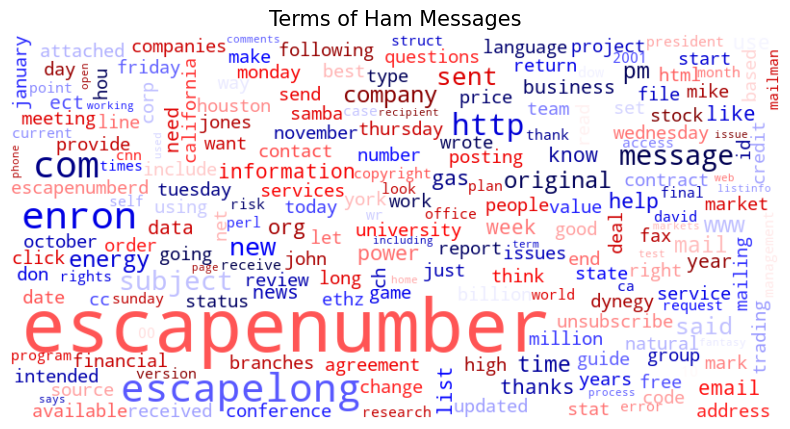

In [15]:

# Separate ham messages
ham = df[df['label'].str.strip().str.lower() == 'ham']

# Tokenize and count terms
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(ham['text'])
term_freq = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with term frequencies
freq_df = pd.DataFrame({'Term': terms, 'Frequency': term_freq})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Prepare data for WordCloud
data = dict(zip(freq_df['Term'], freq_df['Frequency']))

# Create and display the Word Cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='seismic',
                      contour_color='black',
                      contour_width=1).generate_from_frequencies(data)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Terms of Ham Messages', fontsize=15)
plt.show()


#### Bar chart of Spam Messages

In [16]:

# Separate spam messages
spam = df[df['label'].str.strip().str.lower() == 'spam']

# Tokenize and count terms
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(spam['text'])
term_freq = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with term frequencies
freq_df = pd.DataFrame({'Term': terms, 'Frequency': term_freq})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Get the top 10 terms
top_10 = freq_df.head(10)

# Plot using plotly.express
fig = px.bar(top_10, x='Term', y='Frequency', text='Frequency',
             color='Term',
             color_discrete_sequence=px.colors.sequential.PuRd,
             title='Rank of Spam Terms',
             template='simple_white')

# Add black outline to bars
for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### WordCloud of Spam Messages

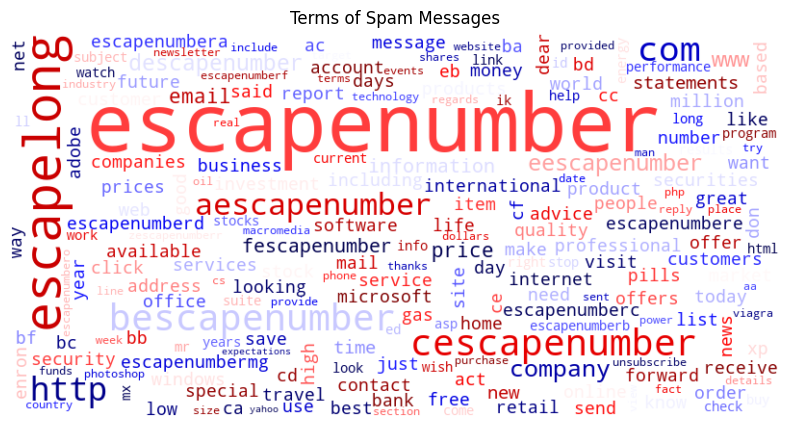

In [13]:
# Separate spam messages
spam = df[df['label'].str.strip().str.lower() == 'spam']

# Tokenize and count terms
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(spam['text'])
term_freq = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with term frequencies
freq_df = pd.DataFrame({'Term': terms, 'Frequency': term_freq})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Convert to dictionary for word cloud
data = dict(zip(freq_df['Term'], freq_df['Frequency']))

# Generate word cloud
spam_wordcloud = WordCloud(background_color='white',
                          colormap='seismic',
                          width=800,
                          height=400,
                          max_words=200).generate_from_frequencies(data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Terms of Spam Messages')
plt.show()


In [17]:
dataset_info = {
    "Number of Rows": len(df),
    "Number of Columns": df.shape[1],
    "Missing Values": df.isnull().sum(),
    "Spam Distribution": df['label'].value_counts(normalize=True) * 100
}

dataset_info

{'Number of Rows': 193852,
 'Number of Columns': 3,
 'Missing Values': label     0
 text      0
 length    0
 dtype: int64,
 'Spam Distribution': label
 Ham     52.699998
 Spam    47.300002
 Name: proportion, dtype: float64}

In [18]:
df.describe(include='all')

,label,text,length
count,193852,193852,1.938520e+05
unique,2,193849,NaN
top,Ham,unsubscribe,NaN
freq,102160,2,NaN
mean,NaN,NaN,1.812761e+03
std,NaN,NaN,2.659496e+04
min,NaN,NaN,1.000000e+00
25%,NaN,NaN,3.620000e+02
50%,NaN,NaN,8.000000e+02
75%,NaN,NaN,1.803000e+03


In [19]:
df.groupby("label").describe()

length                                                        \
          count         mean           std  min    25%    50%     75%   
label                                                                   
Ham    102160.0  2169.701703  36562.473062  1.0  417.0  950.0  1968.0   
Spam    91692.0  1415.069712   2367.960947  1.0  309.0  675.0  1570.0   

                   
              max  
label              
Ham    11510306.0  
Spam     144087.0

In [20]:
df.label.value_counts()

label
Ham     102160
Spam     91692
Name: count, dtype: int64

In [21]:
# Ensure all text data is string and handle missing values
df['text'] = df['text'].astype(str).fillna('')

# Define clean_text function 
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip leading/trailing spaces
    return text

# Apply the cleaning function to the dataset
df['clean_text'] = df['text'].apply(clean_text)

# Check the cleaned text
print(df[['text', 'clean_text']].head())


                                                text  \
0  viiiiiiagraaaa\nonly for the ones that want to...   
1  got ice thought look az original message ice o...   
2  yo ur wom an ne eds an escapenumber in ch ma n...   
3  start increasing your odds of success & live s...   
4  author jra date escapenumber escapenumber esca...   

                                          clean_text  
0  viiiiiiagraaaa only for the ones that want to ...  
1  got ice thought look az original message ice o...  
2  yo ur wom an ne eds an escapenumber in ch ma n...  
3  start increasing your odds of success live sex...  
4  author jra date escapenumber escapenumber esca...  


In [22]:
# Preprocessing
texts = df['clean_text'].values
labels = df['label'].values

In [23]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

#### Data Processing using Sequence Based Method

In [24]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(texts, labels_encoded, test_size=0.2, random_state=42)

# Tokenization and Padding
max_words = 5000
max_len = 150

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

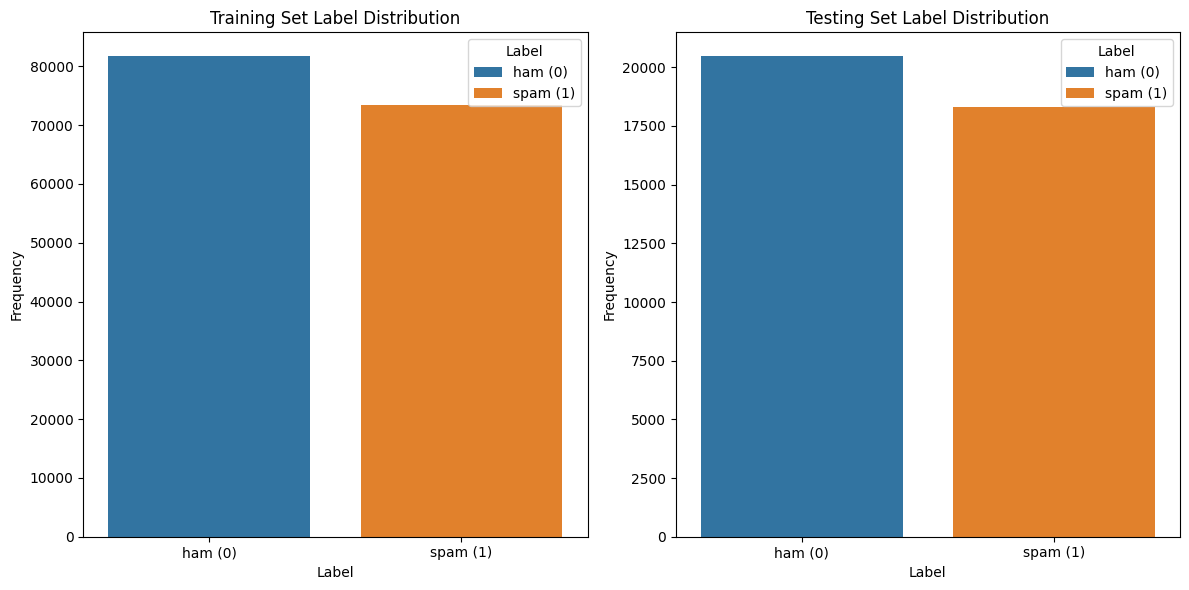

In [25]:
# Create a DataFrame for easy plotting
data = pd.DataFrame({
    'Set': ['Training'] * len(y_train) + ['Testing'] * len(y_test),
    'Label': list(y_train) + list(y_test)
})
# Define colors
color_map = {0: '#1f77b4', 1: '#ff7f0e'}  # Map colors to label
# Plot histograms
plt.figure(figsize=(12, 6))

# Training Set Histogram
plt.subplot(1, 2, 1)
sns.countplot(x='Label', data=data[data['Set'] == 'Training'], hue='Label', palette=color_map)
plt.title('Training Set Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['ham (0)', 'spam (1)'])
plt.legend(title='Label', labels=['ham (0)', 'spam (1)'], loc='upper right')

# Testing Set Histogram
plt.subplot(1, 2, 2)
sns.countplot(x='Label', data=data[data['Set'] == 'Testing'], hue='Label', palette=color_map)
plt.title('Testing Set Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['ham (0)', 'spam (1)'])
plt.legend(title='Label', labels=['ham (0)', 'spam (1)'], loc='upper right')

plt.tight_layout()
plt.show()


#### Advance Individual Model

##### CNN Model

In [26]:

# Parameters for the model
max_words = 5000  # Adjust this based on your vocabulary size

# Define the CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128))  # Removed input_length
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the CNN model instance
model_cnn = create_cnn_model()

# Build the model by specifying the input shape
model_cnn.build(input_shape=(None, max_words))

# Print the model summary
print(model_cnn.summary())

# Show the model architecture with a smaller size
tf.keras.utils.plot_model(
    model_cnn,          
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 5000, 128)      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4996, 64)       │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1249, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1249, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 79936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       799,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,480,405 (5.65 MB)

 Trainable params: 1,480,405 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


##### RNN Model

In [27]:

# Parameters for the model
max_words = 5000  # Adjust this based on your vocabulary size

# Define the RNN model
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128))  # Removed input_length
    model.add(SimpleRNN(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the RNN model instance
model_rnn = create_rnn_model()

# Build the model by specifying the input shape
model_rnn.build(input_shape=(None, max_words))

# Print the model summary
print(model_rnn.summary())

# Show the model architecture with a smaller size
tf.keras.utils.plot_model(
    model_rnn,          # Corrected variable name
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 5000, 128)      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,197 (2.57 MB)

 Trainable params: 674,197 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


##### LSTM Model

In [28]:
# Parameters for the model
max_words = 5000  # Adjust this based on your vocabulary size

# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128))  # Removed input_length
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the LSTM model instance
model_lstm = create_lstm_model()

# Build the model by specifying the input shape
model_lstm.build(input_shape=(None, max_words))

# Print the model summary
print(model_lstm.summary())

# Show the model architecture with a smaller size
tf.keras.utils.plot_model(
    model_lstm,          
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 5000, 128)      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 772,885 (2.95 MB)

 Trainable params: 772,885 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


##### Evaluation of Individual Model

In [29]:

# Define class labels
class_labels = ['ham', 'spam']

# Train and Evaluate Models with Detailed Metrics
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, epochs=50):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    start_time = time.time()
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        validation_split=0.2, 
        verbose=2, 
        callbacks=[early_stopping]
    )
    end_time = time.time()
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    response_time = end_time - start_time
    
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Response Time: {response_time:.4f} seconds")
    
    # Generate classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=class_labels))
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {model_name}:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return history, accuracy, precision, recall, f1, response_time


Epoch 1/50
3877/3877 - 163s - 42ms/step - accuracy: 0.9535 - loss: 0.1196 - val_accuracy: 0.9690 - val_loss: 0.0850
Epoch 2/50
3877/3877 - 196s - 51ms/step - accuracy: 0.9783 - loss: 0.0629 - val_accuracy: 0.9741 - val_loss: 0.0717
Epoch 3/50
3877/3877 - 170s - 44ms/step - accuracy: 0.9851 - loss: 0.0446 - val_accuracy: 0.9758 - val_loss: 0.0765
Epoch 4/50
3877/3877 - 172s - 44ms/step - accuracy: 0.9887 - loss: 0.0337 - val_accuracy: 0.9751 - val_loss: 0.0822
Epoch 5/50
3877/3877 - 196s - 50ms/step - accuracy: 0.9907 - loss: 0.0281 - val_accuracy: 0.9758 - val_loss: 0.0993
Epoch 6/50
3877/3877 - 173s - 45ms/step - accuracy: 0.9918 - loss: 0.0242 - val_accuracy: 0.9766 - val_loss: 0.0915
Epoch 7/50
3877/3877 - 172s - 44ms/step - accuracy: 0.9926 - loss: 0.0221 - val_accuracy: 0.9762 - val_loss: 0.1036
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step

Model: CNN Model
Accuracy: 0.9735
Precision: 0.9725
Recall: 0.9713
F1 Score: 0.9719
Response Time: 1242.0958 seconds

Classification Report fo

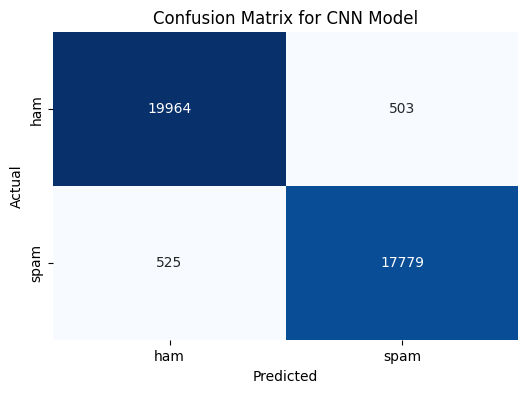

Epoch 1/50
3877/3877 - 396s - 102ms/step - accuracy: 0.8584 - loss: 0.3171 - val_accuracy: 0.9405 - val_loss: 0.1817
Epoch 2/50
3877/3877 - 403s - 104ms/step - accuracy: 0.9127 - loss: 0.2302 - val_accuracy: 0.8265 - val_loss: 0.3906
Epoch 3/50
3877/3877 - 417s - 107ms/step - accuracy: 0.9115 - loss: 0.2322 - val_accuracy: 0.9426 - val_loss: 0.1700
Epoch 4/50
3877/3877 - 405s - 104ms/step - accuracy: 0.9431 - loss: 0.1674 - val_accuracy: 0.9432 - val_loss: 0.2217
Epoch 5/50
3877/3877 - 383s - 99ms/step - accuracy: 0.9418 - loss: 0.1792 - val_accuracy: 0.9432 - val_loss: 0.1721
Epoch 6/50
3877/3877 - 514s - 133ms/step - accuracy: 0.9444 - loss: 0.1648 - val_accuracy: 0.9257 - val_loss: 0.1945
Epoch 7/50
3877/3877 - 378s - 98ms/step - accuracy: 0.9441 - loss: 0.1641 - val_accuracy: 0.9457 - val_loss: 0.1677
Epoch 8/50
3877/3877 - 442s - 114ms/step - accuracy: 0.9531 - loss: 0.1470 - val_accuracy: 0.9486 - val_loss: 0.1601
Epoch 9/50
3877/3877 - 538s - 139ms/step - accuracy: 0.9225 - loss

In [30]:

# Create and evaluate CNN model
cnn_model = create_cnn_model()
cnn_history, cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_response_time = train_and_evaluate_model(
    cnn_model, "CNN Model", X_train_pad, y_train, X_test_pad, y_test)

# Create and evaluate RNN model
rnn_model = create_rnn_model()
rnn_history, rnn_accuracy, rnn_precision, rnn_recall, rnn_f1, rnn_response_time = train_and_evaluate_model(
    rnn_model, "RNN Model", X_train_pad, y_train, X_test_pad, y_test)

# Create and evaluate LSTM model
lstm_model = create_lstm_model()
lstm_history, lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_response_time = train_and_evaluate_model(
    lstm_model, "LSTM Model", X_train_pad, y_train, X_test_pad, y_test)


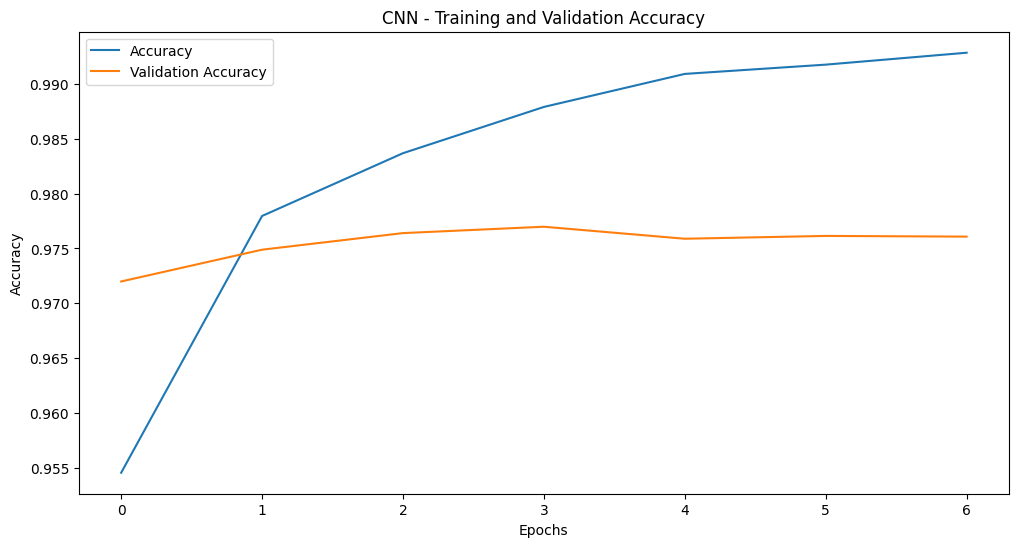

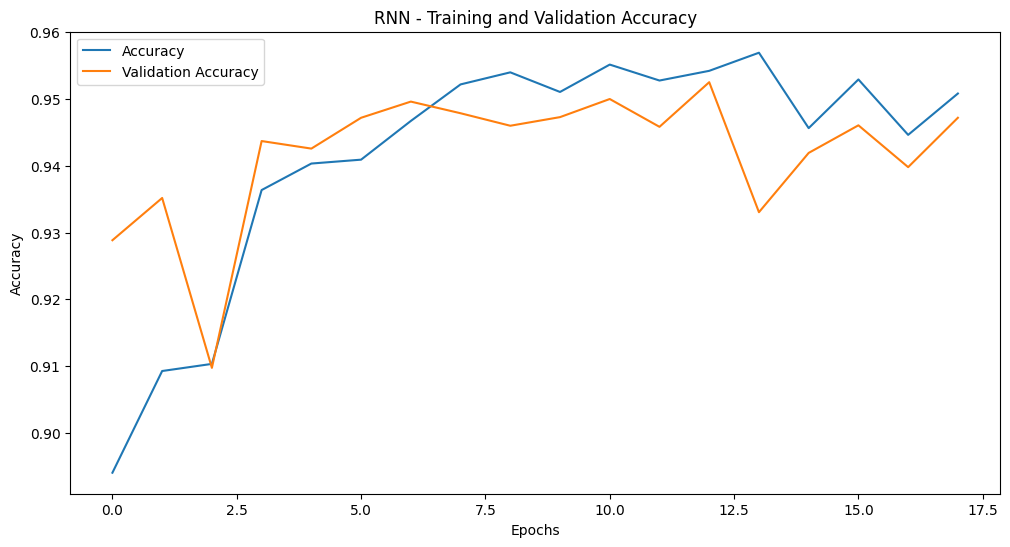

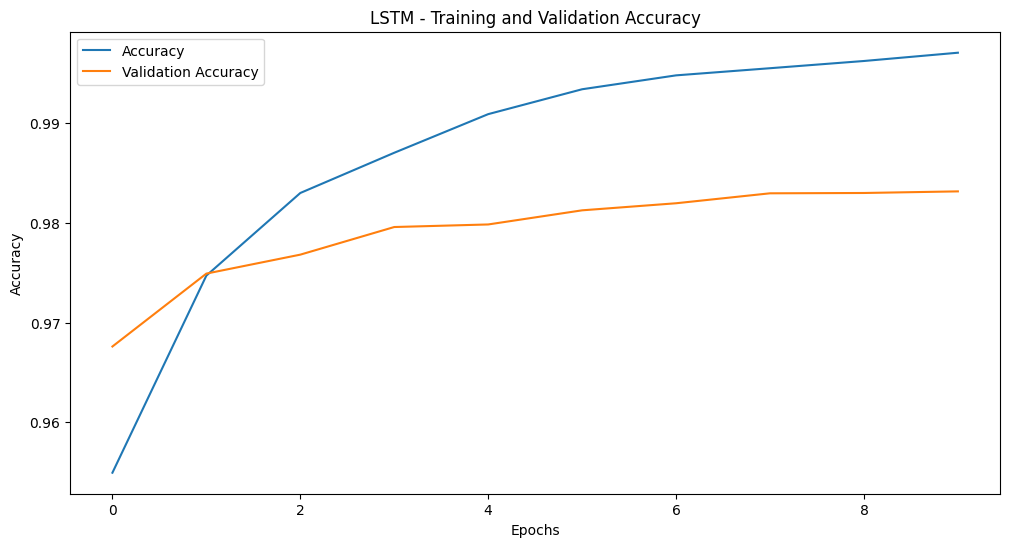

In [28]:

# Plotting training and validation history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(cnn_history, 'CNN')
plot_history(rnn_history, 'RNN')
plot_history(lstm_history, 'LSTM')


##### Comparing the Individual Models

<Figure size 1200x800 with 0 Axes>

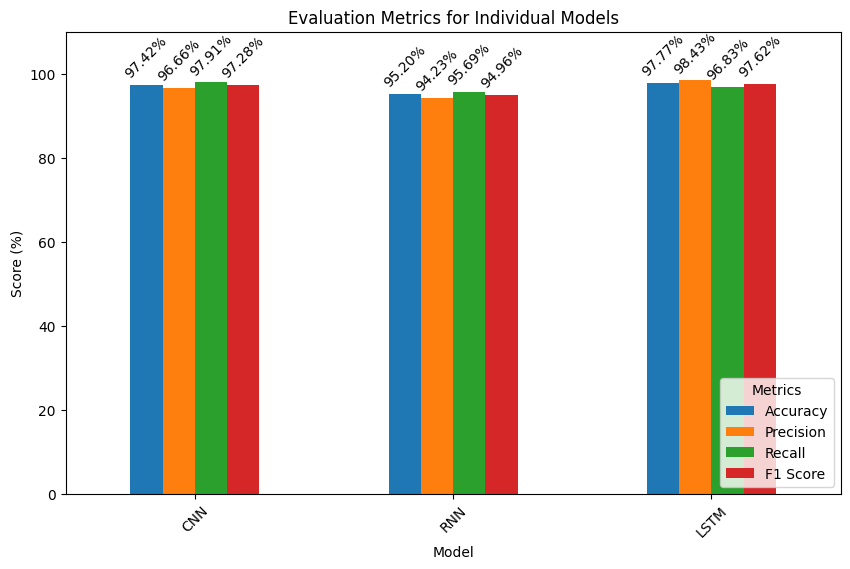

In [29]:

# Define metrics dictionary
metrics = {
    'CNN': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_response_time],
    'RNN': [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1, rnn_response_time],
    'LSTM': [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_response_time]
}

# Define metric names
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create DataFrame for metrics
metrics_df = pd.DataFrame({
    model: [value * 100 for value in values[:-1]]  # Exclude the response time and multiply by 100
    for model, values in metrics.items()
}, index=metric_names).T

# Plot the metrics
plt.figure(figsize=(12, 8))
ax = metrics_df.plot(kind='bar', figsize=(10, 6))

plt.ylim(0, 110)  # Adjust y-axis limits to accommodate percentages

# Add bar labels with diagonal percentage formatting
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=10, rotation=45, label_type='edge')  # Rotate labels

plt.title("Evaluation Metrics for Individual Models")
plt.xlabel("Model")
plt.ylabel("Score (%)")
plt.xticks(rotation=45)
plt.legend(title='Metrics', loc='lower right')
plt.show()


##### ROC curve of the individual models

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 239s 197ms/step


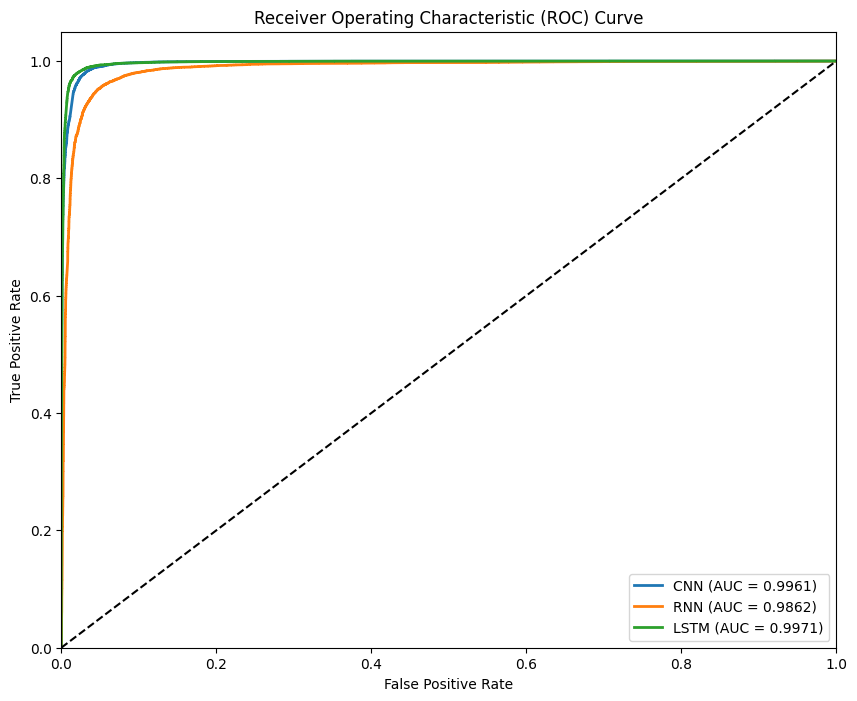

In [43]:

# Function to plot ROC Curves for multiple models
def plot_roc_curves(model_names, y_test, y_pred_probs):
    plt.figure(figsize=(10, 8))

    for model_name, y_pred_prob in zip(model_names, y_pred_probs):
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve with AUC value formatted to four decimal places
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.show()

# Example usage
model_names = ['CNN', 'RNN', 'LSTM']
y_pred_probs = [
    cnn_model.predict(X_test_pad).ravel(),
    rnn_model.predict(X_test_pad).ravel(),
    lstm_model.predict(X_test_pad).ravel()
]

plot_roc_curves(model_names, y_test, y_pred_probs)


#### Hybrid Models Considered

##### CNN-RNN Model

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 150, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 146, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 36, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 707,029 (2.70 MB)

 Trainable params: 707,029 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

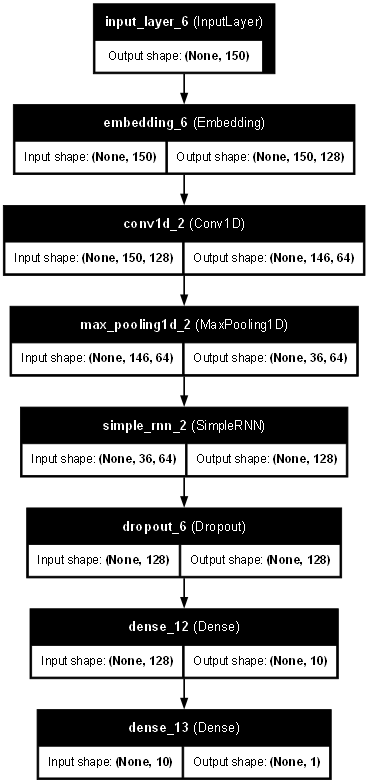

In [31]:
# Import necessary libraries
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, SimpleRNN, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Parameters for the model
max_words = 5000  # The size of the vocabulary (number of unique words to consider)
max_len = 150     # The maximum length of input sequences (padded/truncated)

# Define the CNN-RNN model
def create_cnn_rnn_model():
    input_layer = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=128)(input_layer)
    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = SimpleRNN(128, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='relu')(x)  # Consider adjusting the number of units here based on your problem
    output_layer = Dense(1, activation='sigmoid')(x)  # For binary classification
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the CNN-RNN model instance
model_cnn_rnn = create_cnn_rnn_model()

# Print the model summary
model_cnn_rnn.summary()

# Show the model architecture
tf.keras.utils.plot_model(
    model_cnn_rnn,          
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### CNN-LSTM model

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 150, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 146, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 36, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 781,141 (2.98 MB)

 Trainable params: 781,141 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

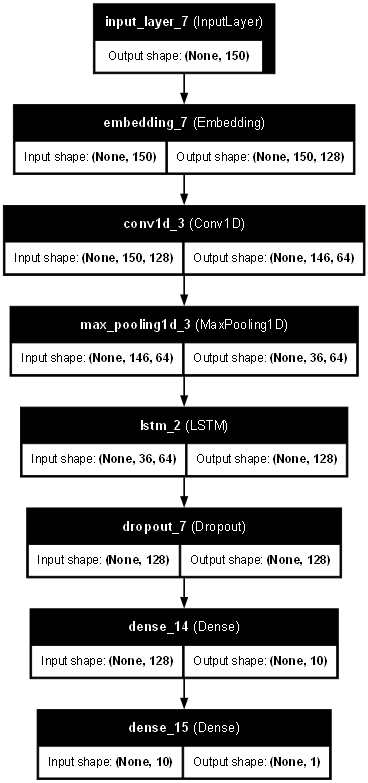

In [32]:

# Parameters for the model
max_words = 5000  # The size of the vocabulary (number of unique words to consider)
max_len = 150     # The maximum length of input sequences (padded/truncated)

# Define the CNN-LSTM model
def create_cnn_lstm_model():
    input_layer = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=128)(input_layer)  # Embedding layer for word vectors
    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)      # Convolutional layer for feature extraction
    x = MaxPooling1D(pool_size=4)(x)                                 # Max pooling layer to downsample the input
    x = LSTM(128, return_sequences=False)(x)                         # LSTM layer for sequential data processing
    x = Dropout(0.5)(x)                                              # Dropout layer for regularization
    x = Dense(10, activation='relu')(x)                              # Dense layer for further processing
    output_layer = Dense(1, activation='sigmoid')(x)                 # Output layer for binary classification
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the CNN-LSTM model instance
model_cnn_lstm = create_cnn_lstm_model()

# Print the model summary
model_cnn_lstm.summary()

# Show the model architecture
tf.keras.utils.plot_model(
    model_cnn_lstm,          
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### RNN-LSTM Model

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 150, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 150, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,781 (3.07 MB)

 Trainable params: 805,781 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

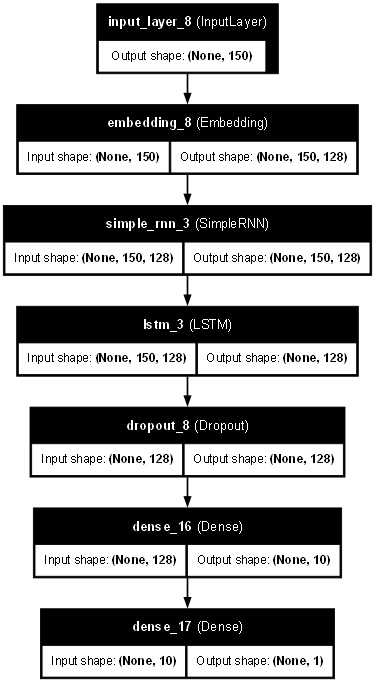

In [33]:

# Parameters for the model
max_words = 5000  # The size of the vocabulary (number of unique words to consider)
max_len = 150     # The maximum length of input sequences (padded/truncated)

# Define the RNN-LSTM model
def create_rnn_lstm_model():
    input_layer = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=128)(input_layer)  # Embedding layer for word vectors
    x = SimpleRNN(128, return_sequences=True)(x)                     # SimpleRNN layer for short-term dependencies
    x = LSTM(128, return_sequences=False)(x)                         # LSTM layer for long-term dependencies
    x = Dropout(0.5)(x)                                              # Dropout layer for regularization
    x = Dense(10, activation='relu')(x)                              # Dense layer for further processing
    output_layer = Dense(1, activation='sigmoid')(x)                 # Output layer for binary classification
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the RNN-LSTM model instance
model_rnn_lstm = create_rnn_lstm_model()

# Print the model summary
model_rnn_lstm.summary()

# Show the model architecture
tf.keras.utils.plot_model(
    model_rnn_lstm,          
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### Evaluation of Each Combination

Training CNN-RNN model...
Epoch 1/50
3877/3877 - 407s - 105ms/step - accuracy: 0.9445 - loss: 0.1463 - val_accuracy: 0.9629 - val_loss: 0.1087
Epoch 2/50
3877/3877 - 364s - 94ms/step - accuracy: 0.9670 - loss: 0.0972 - val_accuracy: 0.9686 - val_loss: 0.0922
Epoch 3/50
3877/3877 - 354s - 91ms/step - accuracy: 0.9749 - loss: 0.0727 - val_accuracy: 0.9646 - val_loss: 0.1068
Epoch 4/50
3877/3877 - 354s - 91ms/step - accuracy: 0.9782 - loss: 0.0684 - val_accuracy: 0.9689 - val_loss: 0.0990
Epoch 5/50
3877/3877 - 358s - 92ms/step - accuracy: 0.9837 - loss: 0.0497 - val_accuracy: 0.9682 - val_loss: 0.0935
Epoch 6/50
3877/3877 - 361s - 93ms/step - accuracy: 0.9875 - loss: 0.0400 - val_accuracy: 0.9709 - val_loss: 0.0930
Epoch 7/50
3877/3877 - 368s - 95ms/step - accuracy: 0.9895 - loss: 0.0341 - val_accuracy: 0.9714 - val_loss: 0.1003
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step


<Figure size 600x400 with 0 Axes>

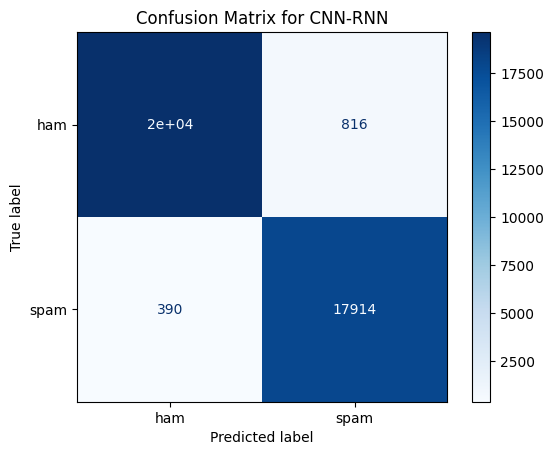

CNN-RNN model metrics:
Accuracy: 0.9689
Precision: 0.9564
Recall: 0.9787
F1 Score: 0.9674

Classification Report for CNN-RNN:
               precision    recall  f1-score   support

         ham       0.98      0.96      0.97     20467
        spam       0.96      0.98      0.97     18304

    accuracy                           0.97     38771
   macro avg       0.97      0.97      0.97     38771
weighted avg       0.97      0.97      0.97     38771

Training CNN-LSTM model...
Epoch 1/50
3877/3877 - 523s - 135ms/step - accuracy: 0.9545 - loss: 0.1198 - val_accuracy: 0.9695 - val_loss: 0.0818
Epoch 2/50
3877/3877 - 525s - 135ms/step - accuracy: 0.9794 - loss: 0.0606 - val_accuracy: 0.9744 - val_loss: 0.0725
Epoch 3/50
3877/3877 - 516s - 133ms/step - accuracy: 0.9870 - loss: 0.0392 - val_accuracy: 0.9758 - val_loss: 0.0752
Epoch 4/50
3877/3877 - 513s - 132ms/step - accuracy: 0.9913 - loss: 0.0265 - val_accuracy: 0.9774 - val_loss: 0.0793
Epoch 5/50
3877/3877 - 540s - 139ms/step - accuracy

<Figure size 600x400 with 0 Axes>

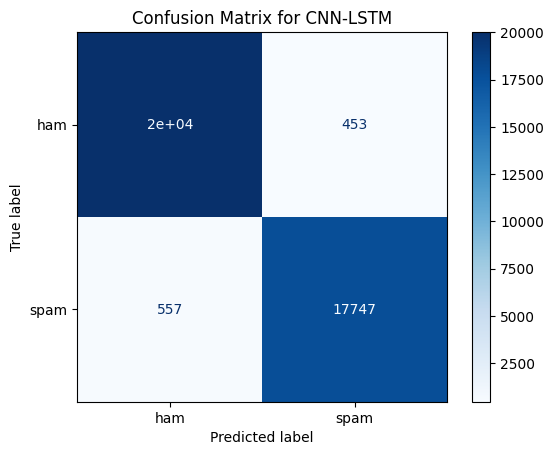

CNN-LSTM model metrics:
Accuracy: 0.9739
Precision: 0.9751
Recall: 0.9696
F1 Score: 0.9723

Classification Report for CNN-LSTM:
               precision    recall  f1-score   support

         ham       0.97      0.98      0.98     20467
        spam       0.98      0.97      0.97     18304

    accuracy                           0.97     38771
   macro avg       0.97      0.97      0.97     38771
weighted avg       0.97      0.97      0.97     38771

Training RNN-LSTM model...
Epoch 1/50
3877/3877 - 1583s - 408ms/step - accuracy: 0.9189 - loss: 0.2150 - val_accuracy: 0.9533 - val_loss: 0.1314
Epoch 2/50
3877/3877 - 1575s - 406ms/step - accuracy: 0.9636 - loss: 0.1094 - val_accuracy: 0.9422 - val_loss: 0.1698
Epoch 3/50
3877/3877 - 1546s - 399ms/step - accuracy: 0.9650 - loss: 0.1038 - val_accuracy: 0.9651 - val_loss: 0.1120
Epoch 4/50
3877/3877 - 1575s - 406ms/step - accuracy: 0.9724 - loss: 0.0812 - val_accuracy: 0.9693 - val_loss: 0.0925
Epoch 5/50
3877/3877 - 1862s - 480ms/step - a

<Figure size 600x400 with 0 Axes>

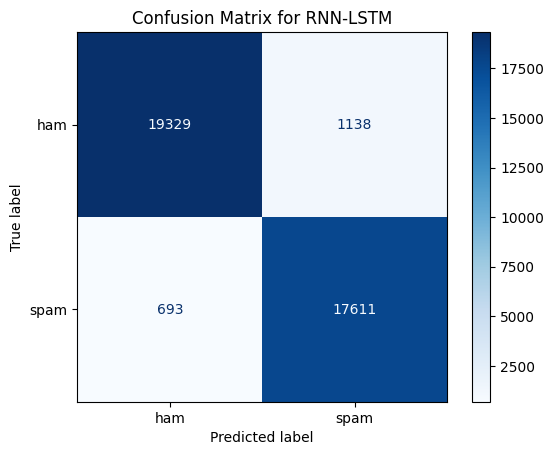

RNN-LSTM model metrics:
Accuracy: 0.9528
Precision: 0.9393
Recall: 0.9621
F1 Score: 0.9506

Classification Report for RNN-LSTM:
               precision    recall  f1-score   support

         ham       0.97      0.94      0.95     20467
        spam       0.94      0.96      0.95     18304

    accuracy                           0.95     38771
   macro avg       0.95      0.95      0.95     38771
weighted avg       0.95      0.95      0.95     38771



In [34]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping

# Define combined models (ensure model creation functions are implemented)
combined_models = {
    'CNN-RNN': create_cnn_rnn_model(),
    'CNN-LSTM': create_cnn_lstm_model(),
    'RNN-LSTM': create_rnn_lstm_model()
}

class_labels = ['ham', 'spam']

# Dictionary to store metrics and history of each model
metric_combine = {}
history_combine = {}

# Initialize a dictionary to store classification reports and confusion matrices
reports = {}

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for name, model in combined_models.items():
    print(f"Training {name} model...")
    
    # Train the model with EarlyStopping callback and save the training history
    history = model.fit(
        X_train_pad, 
        y_train, 
        epochs=50, 
        batch_size=32, 
        validation_split=0.2, 
        verbose=2, 
        callbacks=[early_stopping]  # Add the callback here
    )
    history_combine[name] = history.history  # Save history

    # Evaluate the model on test data
    y_pred = (model.predict(X_test_pad) > 0.5).astype("int32").flatten()
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metric_combine[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    
    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=class_labels)
    reports[name] = report
    
    print(f"{name} model metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\n")
    print(f"Classification Report for {name}:\n", report)


##### Training History for the Hybrid Models

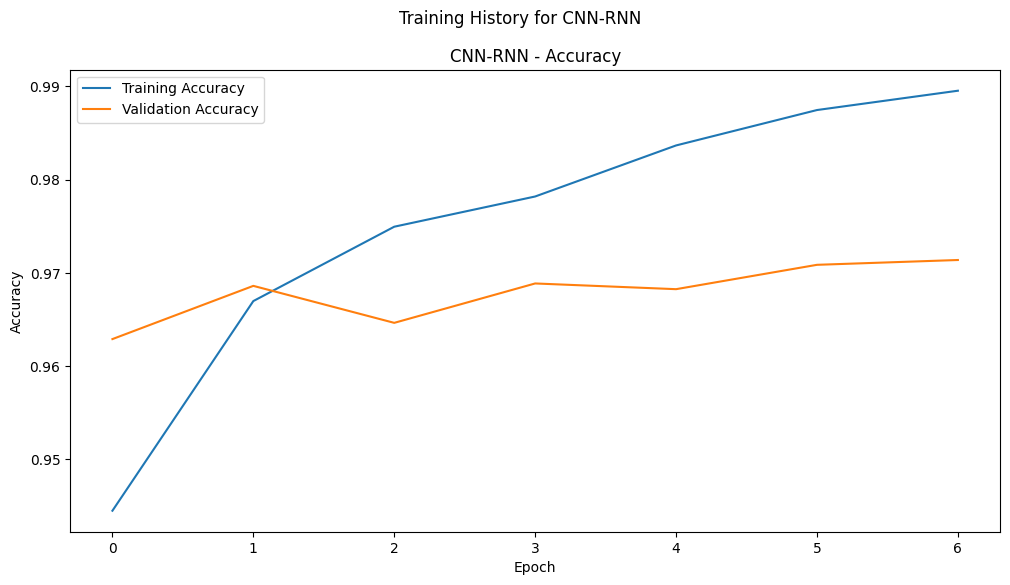

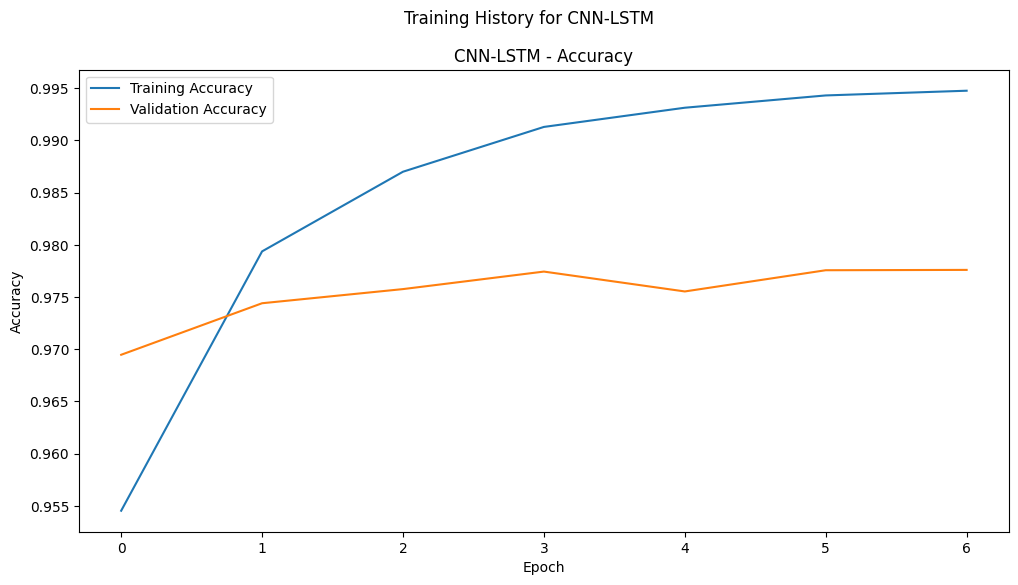

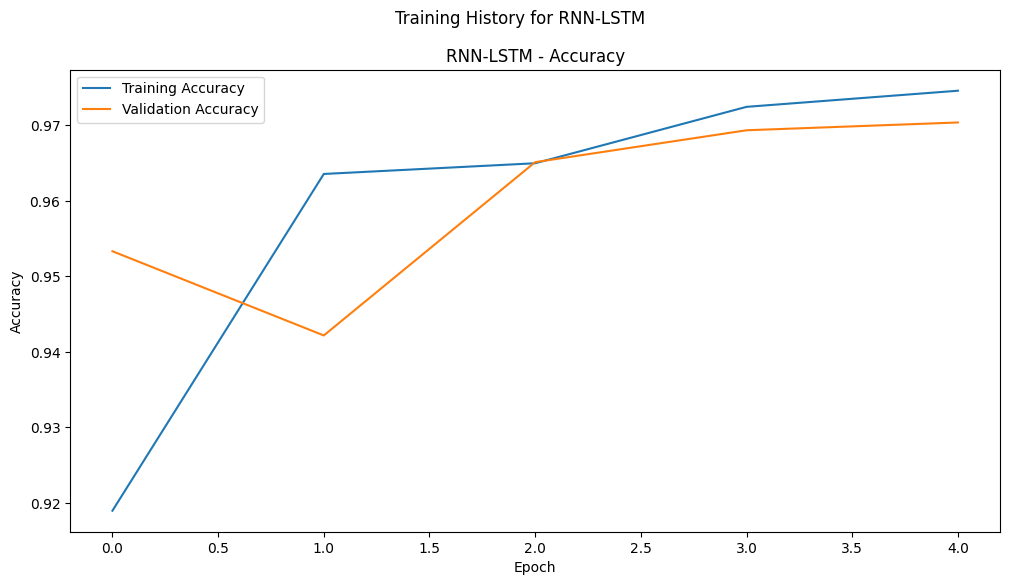

In [35]:

# Plot training history for each model
for name, history in history_combine.items():
    plt.figure(figsize=(12, 6))
    
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
   
    plt.suptitle(f'Training History for {name}')
    plt.show()

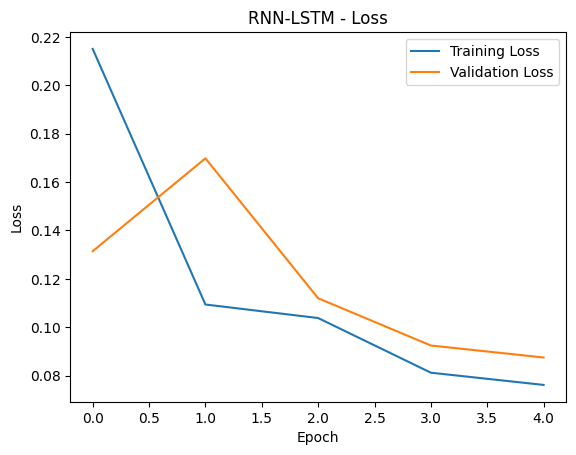

In [36]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    

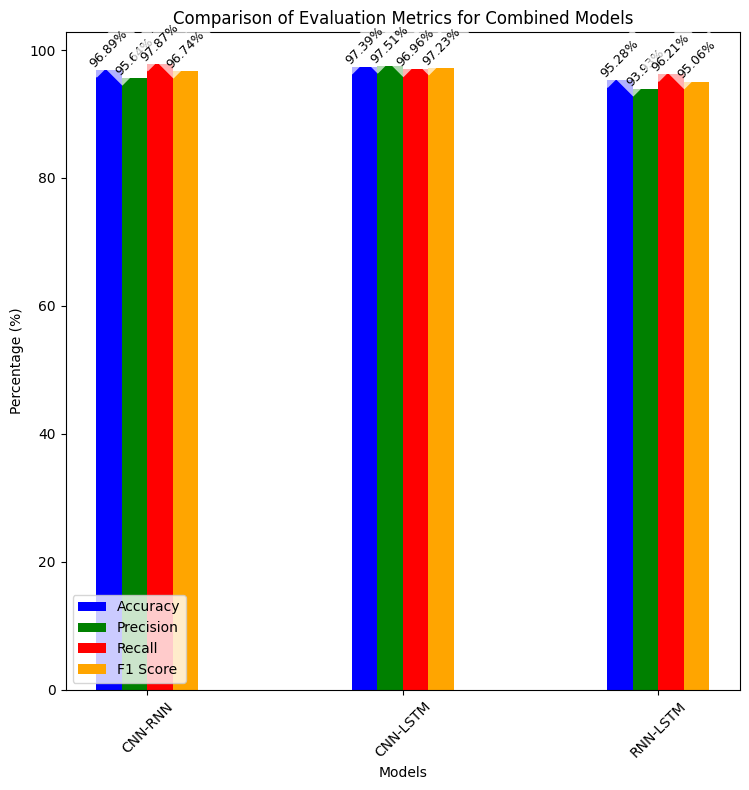

In [37]:
# Convert metrics dictionary to a DataFrame for easier plotting
metrics_df = pd.DataFrame(metric_combine).T

# Define plot size
plt.figure(figsize=(8, 8))

# Define bar width and positions
bar_width = 0.1
index = np.arange(len(metrics_df))

# Plot each metric
for i, metric in enumerate(metrics_df.columns):
    bars = plt.bar(index + i * bar_width, metrics_df[metric] * 100, bar_width, 
                   label=metric, color=['blue', 'green', 'red', 'orange'][i])
    
    # Annotate bars with the exact percentage value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', 
                 ha='center', va='bottom', fontsize=9, rotation=45, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Evaluation Metrics for Combined Models')

# Adjust x-axis labels to avoid overlap
plt.xticks(index + bar_width * (len(metrics_df.columns) / 2) - bar_width / 2, metrics_df.index, rotation=45)

# Adjust plot margins to ensure everything fits
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the margins

plt.legend(loc='best')
plt.show()

##### Roc of Best Hybrid

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 285s 235ms/step


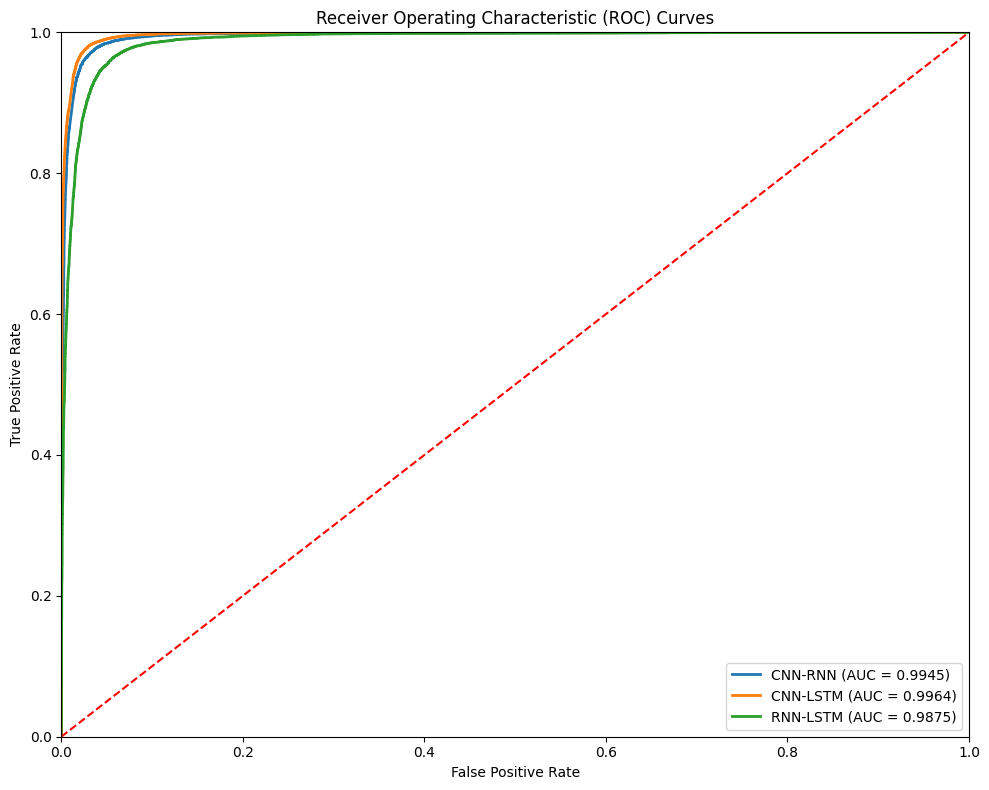

In [38]:

# Prepare the figure
plt.figure(figsize=(10, 8))

# Iterate over each model to compute and plot ROC curve
for model_name, model in combined_models.items():
    # Predict probabilities
    y_proba = model.predict(X_test_pad).flatten()
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Plot the diagonal line (no redundant arguments)
plt.plot([0, 1], [0, 1], 'r--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


#### Comparison of All Models

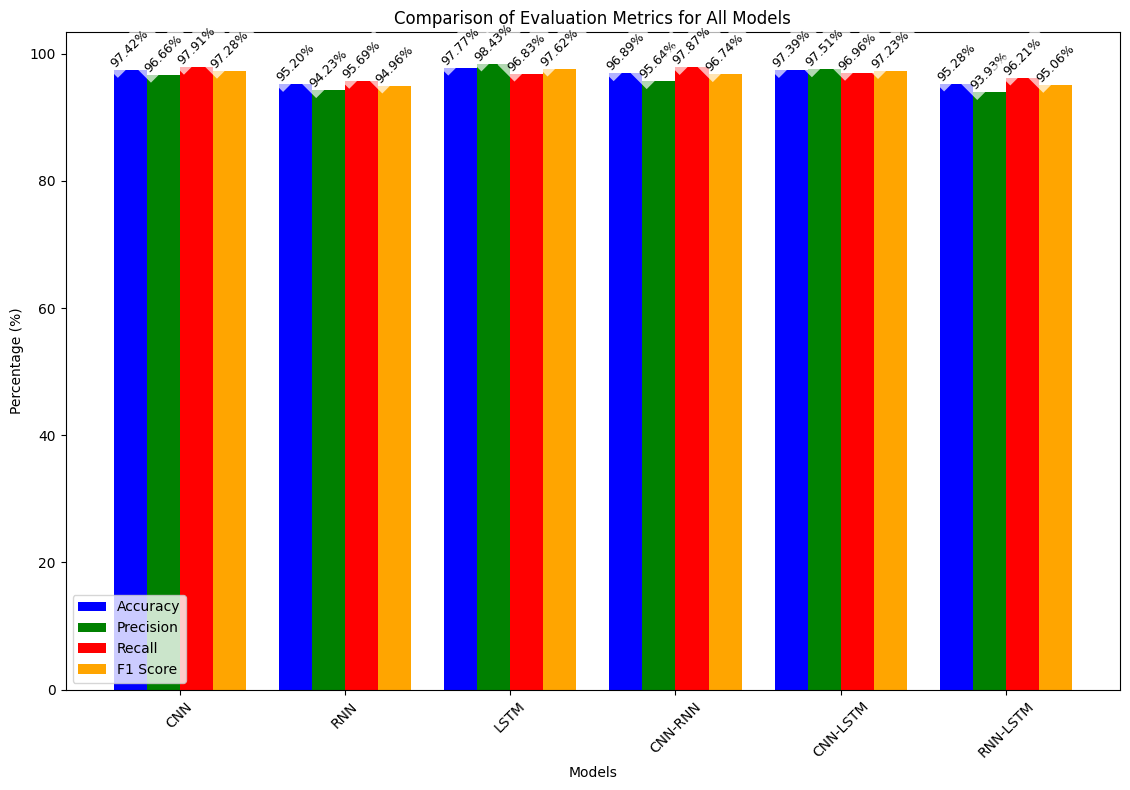

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have the metrics for all models in a dictionary similar to `metric_combine`
all_models_metrics = {
    'CNN': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1],
    'RNN': [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1],
    'LSTM': [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1],
    'CNN-RNN': [metric_combine['CNN-RNN']['Accuracy'], 
                metric_combine['CNN-RNN']['Precision'],
                metric_combine['CNN-RNN']['Recall'],
                metric_combine['CNN-RNN']['F1 Score']],
    'CNN-LSTM': [metric_combine['CNN-LSTM']['Accuracy'], 
                 metric_combine['CNN-LSTM']['Precision'],
                 metric_combine['CNN-LSTM']['Recall'],
                 metric_combine['CNN-LSTM']['F1 Score']],
    'RNN-LSTM': [metric_combine['RNN-LSTM']['Accuracy'], 
                 metric_combine['RNN-LSTM']['Precision'],
                 metric_combine['RNN-LSTM']['Recall'],
                 metric_combine['RNN-LSTM']['F1 Score']]
}

# Convert metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(all_models_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score']).T

# Define plot size
plt.figure(figsize=(12, 8))

# Define bar width and positions
bar_width = 0.2
index = np.arange(len(metrics_df))

# Plot each metric
for i, metric in enumerate(metrics_df.columns):
    bars = plt.bar(index + i * bar_width, metrics_df[metric] * 100, bar_width, 
                   label=metric, color=['blue', 'green', 'red', 'orange'][i])
    
    # Annotate bars with the exact percentage value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', 
                 ha='center', va='bottom', fontsize=9, rotation=45, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Evaluation Metrics for All Models')

# Adjust x-axis labels to avoid overlap
plt.xticks(index + bar_width * (len(metrics_df.columns) / 2) - bar_width / 2, metrics_df.index, rotation=45)

# Adjust plot margins to ensure everything fits
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the margins

plt.legend(loc='best')
plt.show()


RECOMMENDATIONS
Pickle Tool for Model Serialization

In the context of email classification, the Pickle tool plays a crucial role in the process of model serialization and deserialization. Pickle is a Python module used to save trained machine learning models to disk and later load them back into memory for use in applications, such as the Streamlit web app developed in this research.However, during the testing phase, it was observed that the application consistently classified all inputs as "Ham," indicating a potential issue with the spam classification function. 
 
 link : https://email-classification-into-ham-or-spam2-fxar2jnqsetmzwugrjuktw.streamlit.app

In [ ]:
# best training model in  hybrid models
model_cnn_lstm.save('cnn_lstm.h5')  # Save model to HDF5 format